## Import libraries 

In [43]:
import requests
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import sklearn
import wordcloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn import metrics
import sklearn.metrics as metrics

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import joblib

In [44]:
#!pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 8
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Reading the data

In [45]:
# Reading CSV file as a DataFrame
violations = pd.read_csv('../../Data/Food_Inspections.csv')

In [46]:
violations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251211 entries, 0 to 251210
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Inspection ID    251211 non-null  int64  
 1   DBA Name         251211 non-null  object 
 2   AKA Name         248719 non-null  object 
 3   License #        251203 non-null  float64
 4   Facility Type    246168 non-null  object 
 5   Risk             251136 non-null  object 
 6   Address          251211 non-null  object 
 7   City             251038 non-null  object 
 8   State            251164 non-null  object 
 9   Zip              251134 non-null  float64
 10  Inspection Date  251211 non-null  object 
 11  Inspection Type  251210 non-null  object 
 12  Results          251211 non-null  object 
 13  Violations       182774 non-null  object 
 14  Latitude         250346 non-null  float64
 15  Longitude        250346 non-null  float64
 16  Location         250346 non-null  obje

In [47]:
violations.sample(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
19416,2555893,BEATRIX,BEATRIX,2836105.0,Restaurant,Risk 1 (High),155 N WACKER DR,CHICAGO,IL,60606.0,05/17/2022,License,Pass,NaN,41.884616,-87.636682,"(41.88461561705127, -87.63668235780031)"
84088,2177098,T & B GRILL,MARISCOS SIRENA,2405739.0,Restaurant,Risk 1 (High),3658 W LAWRENCE AVE,CHICAGO,IL,60625.0,06/08/2018,Canvass,Out of Business,NaN,41.968433,-87.720638,"(41.96843262999754, -87.72063795688788)"
200790,1230091,GROTA RESTAURANT,GROTA RESTAURANT,6753.0,Restaurant,Risk 1 (High),3108-3112 N CENTRAL AVE,CHICAGO,IL,60634.0,07/13/2012,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.937067,-87.766592,"(41.93706710815131, -87.76659233846347)"


In [48]:
violations.Results.value_counts()

Pass                    129441
Fail                     48794
Pass w/ Conditions       38663
Out of Business          21485
No Entry                  9697
Not Ready                 3050
Business Not Located        81
Name: Results, dtype: int64

## Pre Processing

In [49]:
# Selecting only records with Results = Fail
inspections = violations[(violations['Results'] == 'Fail') | (violations['Results'] == 'Pass')][['Results', 'Violations']]
inspections.shape

(178235, 2)

In [50]:
# Checking number of missing Violations
inspections.Violations.isnull().sum()

34120

In [51]:
# Cleaning the data by dropping entries with missing Violations
inspections = inspections[inspections['Violations'].notna()]
inspections.Violations.isnull().sum()

0

In [52]:
# Extracting only comments from the 'Violations' column
comments = []
for violation in inspections['Violations']:
    # Using regular expression to find only the comments
    reg_exp = r'Comments:\s*(.*?)(?=\||$)'
    matches = re.findall(reg_exp, violation)
    comments.append(matches)

# Adding extracted comments as a new column in the DataFrame
inspections.loc[:,'Comments'] = comments

# To make sure there are no null comments 
inspections.Comments.isnull().sum()

0

In [53]:
# Define a function to clean the text data
def clean_text(text):
    
    # Convert to lowercase
    text = text.lower()
    
    tokens = nltk.word_tokenize(text)
    
    # Remove single-character tokens (mostly punctuation)
    tokens = [token for token in tokens if len(token) > 1]

    # Remove numbers
    tokens = [token for token in tokens if not token.isnumeric()]

    # Remove punctuation
    tokens = [token for token in tokens if token.isalpha()]

    # Remove stop words and lemmatize the words
    stop_words = set(nltk.corpus.stopwords.words('english'))   
    
    wnl = nltk.WordNetLemmatizer()
    tokens=[wnl.lemmatize(token) for token in tokens if not token in stop_words]
    
    # Join the tokens back into a string
    clean_text = ' '.join(tokens)
    return clean_text

# Joining all list contents to one big string
inspections['Comments_Tokens'] = inspections['Comments'].parallel_apply(lambda x: ' '.join(x))

# Cleaning the text and tokenising it
inspections['Comments_Tokens'] = inspections['Comments_Tokens'].parallel_apply(lambda x: clean_text(x))

# Converting label to a binary numerical variable
inspections['Results_Flag'] = inspections.Results.map({'Fail':0, 'Pass':1})
inspections.head(3)

As seen in opur previous assignment, lemmatization is a more powerful technique than stemming because it produces more accurate and meaningful base words, takes into account the context and part of speech of the words, and is language-specific. Though lemmatization may be slower and more computationally intensive than stemming we have chosen <b> Lemmatization</b> for pre-processing our comments.

## Train Test Split

In [12]:
# define X and y
X = inspections.Comments_Tokens
y = inspections.Results_Flag

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (144115,)
y Shape: (144115,)


Splitting data into train and test sets. We will use the train set to train the CountVectorizer and the model, and the test set to evaluate the model's performance.

In [13]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (108086,) y_train: (108086,)
Testing records, X_test: (36029,) y_test: (36029,)


## Building and evaluating models

We will first start out by running and evaluating the performance of our basic models with no parameters

### a. Count Vectorizer and Naive Bayes

In [14]:
# Define the pipeline
pipeline_count_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

# Train the model
pipeline_count_nb.fit(X_train, y_train)

# make class predictions for X_test
y_pred_count_nb = pipeline_count_nb.predict(X_test)

# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_count_nb) * 100:.1f}%")

# calculate the confusion matrix
print("Confusion matrix:\n ",metrics.confusion_matrix(y_test, y_pred_count_nb))

# calculate precision and recall
print("Classification Report:\n",classification_report(y_test, y_pred_count_nb))

Test Accuracy: 91.3%
Confusion matrix:
  [[10172   988]
 [ 2150 22719]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87     11160
           1       0.96      0.91      0.94     24869

    accuracy                           0.91     36029
   macro avg       0.89      0.91      0.90     36029
weighted avg       0.92      0.91      0.91     36029



In [15]:
proba_count_nb = pipeline_count_nb.predict_proba(X_test)

# calculate AUC score 
print(f"AUC Score for Count Vectorizer and Naive Bayes : {roc_auc_score(y_test, proba_count_nb[:, 1])* 100:.1f}%")

AUC Score for Count Vectorizer and Naive Bayes : 94.7%


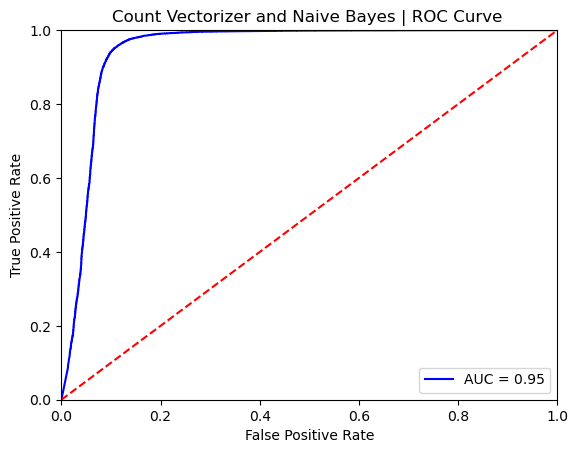

In [16]:
def plot_roc_auc_curve(y_test, prob, title):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title(title + ' | ROC Curve ')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_roc_auc_curve(y_test, proba_count_nb[:, 1], 'Count Vectorizer and Naive Bayes')

### b. Count Vectorizer and Logistic Regression

In [17]:
# Define the pipeline
pipeline_count_log = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(max_iter=10000))
])

# Train the model
pipeline_count_log.fit(X_train, y_train)

# make class predictions for X_test
y_pred_count_log = pipeline_count_log.predict(X_test)

# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_count_log) * 100:.1f}%")

# calculate the confusion matrix
print("Confusion matrix:\n ",metrics.confusion_matrix(y_test, y_pred_count_log))

# calculate precision and recall
print("Classification Report:\n",classification_report(y_test, y_pred_count_log))

Test Accuracy: 97.8%
Confusion matrix:
  [[10560   600]
 [  205 24664]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96     11160
           1       0.98      0.99      0.98     24869

    accuracy                           0.98     36029
   macro avg       0.98      0.97      0.97     36029
weighted avg       0.98      0.98      0.98     36029



In [18]:
proba_count_log = pipeline_count_log.predict_proba(X_test)

# calculate AUC score 
print(f"AUC Score Count Vectorizer and Logistic Regression : {roc_auc_score(y_test, proba_count_log[:, 1])* 100:.1f}%")

AUC Score Count Vectorizer and Logistic Regression : 99.3%


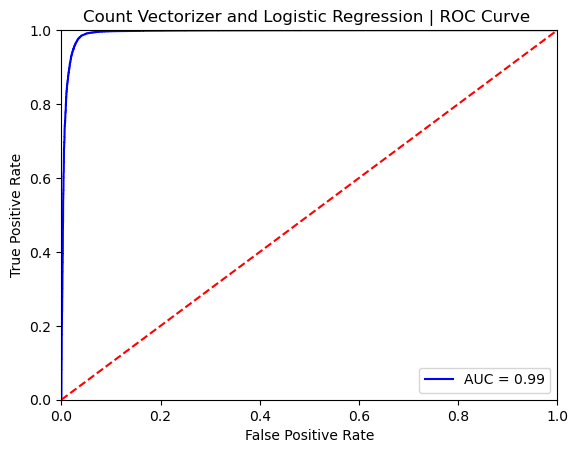

In [19]:
plot_roc_auc_curve(y_test, proba_count_log[:, 1], 'Count Vectorizer and Logistic Regression')

#### Logistic regression seems to perform better than Naive Bayes and hence we can go ahead and visualise the most important features from our logistic regression model

In [20]:
def important_features_viz(clf, vect, top, order):
    feature_names = vect.get_feature_names_out()
    coefs_with_fns = zip(feature_names, clf.coef_[0])

    coefs_with_fns_df = pd.DataFrame(coefs_with_fns,
                        columns=['feature', 'coefficient'])
    coefs_with_fns_df.sort_values(by='coefficient', ascending=top, inplace=True)

    top_features_df = coefs_with_fns_df.copy()
    top_features_df['coefficient'] = top_features_df['coefficient']*(order)

    data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


    wordcloud_obj = wordcloud.WordCloud(
        width = 1000,
        height = 500,
        background_color = 'white',
        max_words=30,
        stopwords = wordcloud.STOPWORDS)

    wordcloud_obj.generate_from_frequencies(data)

    fig = plt.figure(
        figsize = (20, 10),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud_obj, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    
    return coefs_with_fns_df.head(10)

### Top Features of the FAIL class using CountVectorizer + LogisticRegression

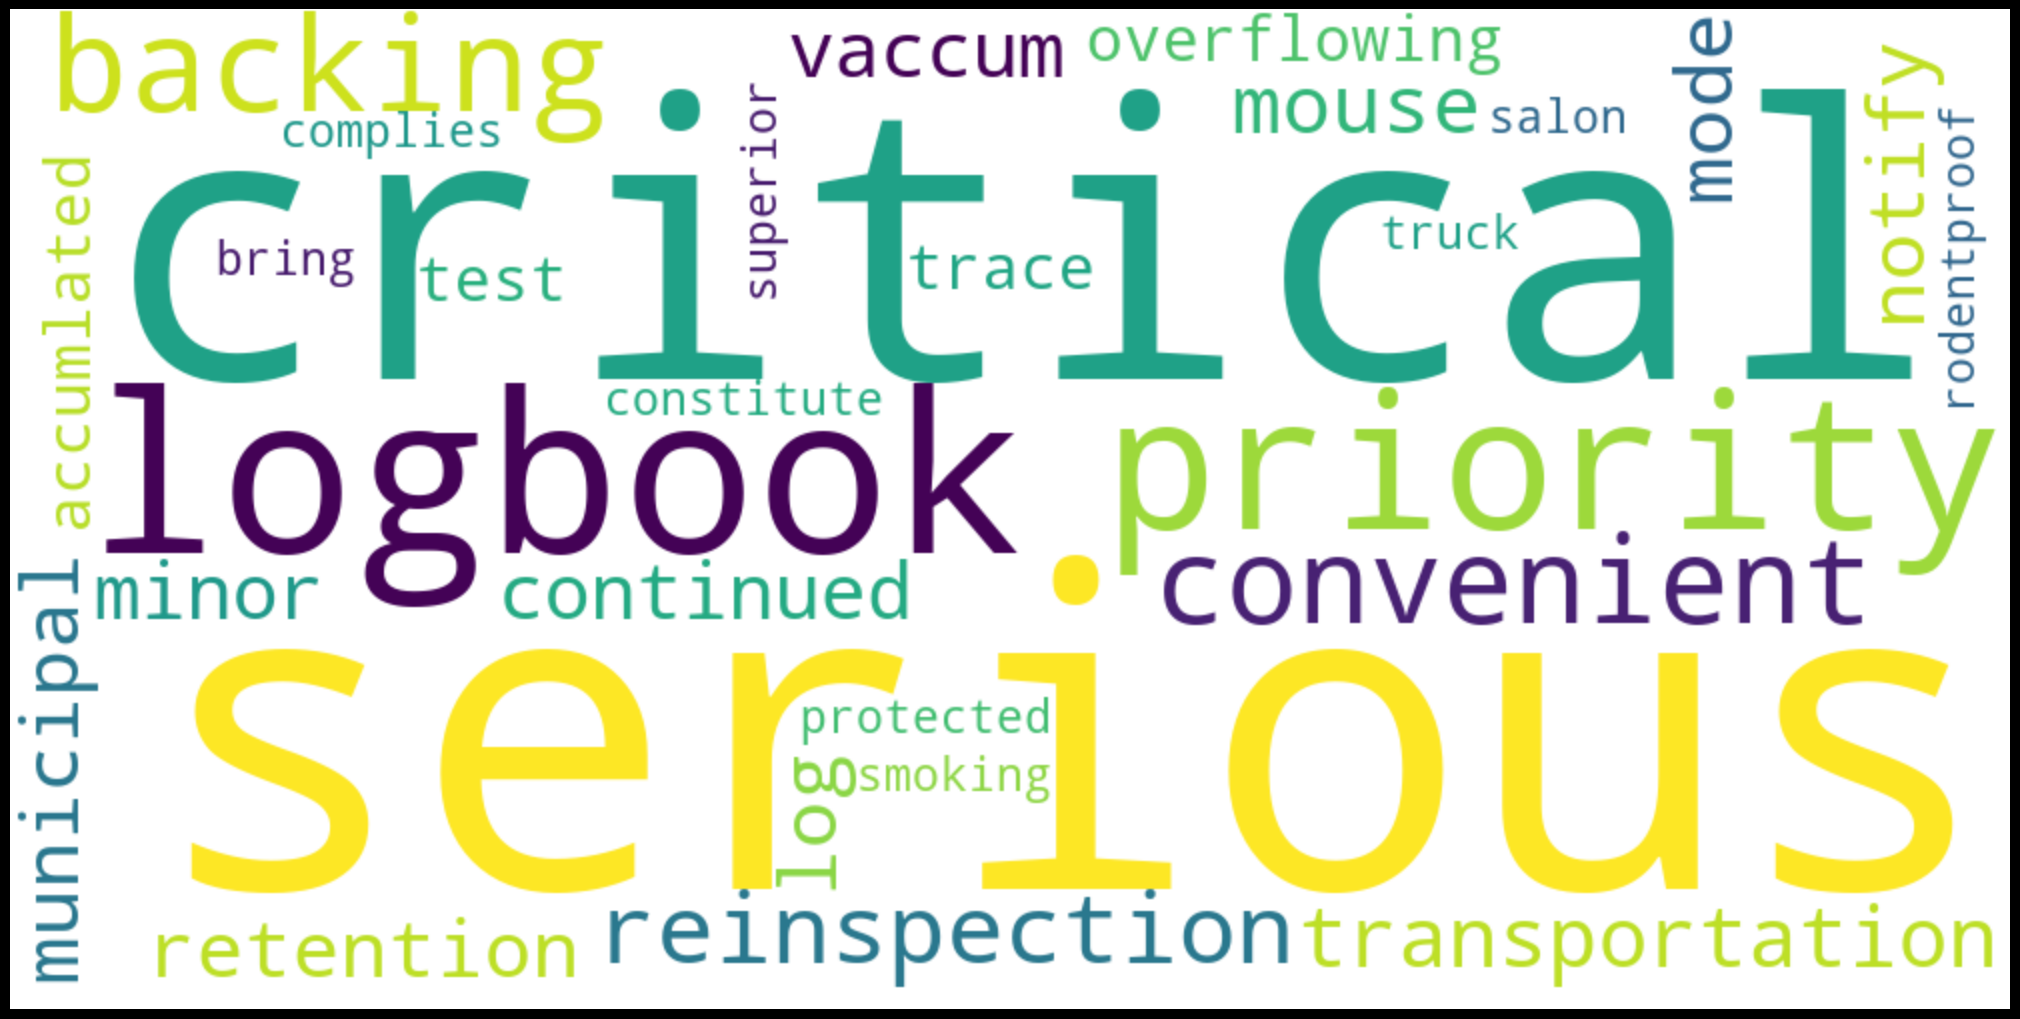

,feature,coefficient
18709,serious,-6.983816
5257,critical,-5.174969
12234,logbook,-4.013493
15934,priority,-3.826850
1480,backing,-2.690707
4784,convenient,-2.548107
17067,reinspection,-2.375428
21682,transportation,-2.308666
13356,mouse,-2.251568
13231,mode,-2.191701


In [21]:
important_features_viz(pipeline_count_log.named_steps['clf'], pipeline_count_log.named_steps['vect'], True, -10)

### Top Features of the PASS class using CountVectorizer + LogisticRegression

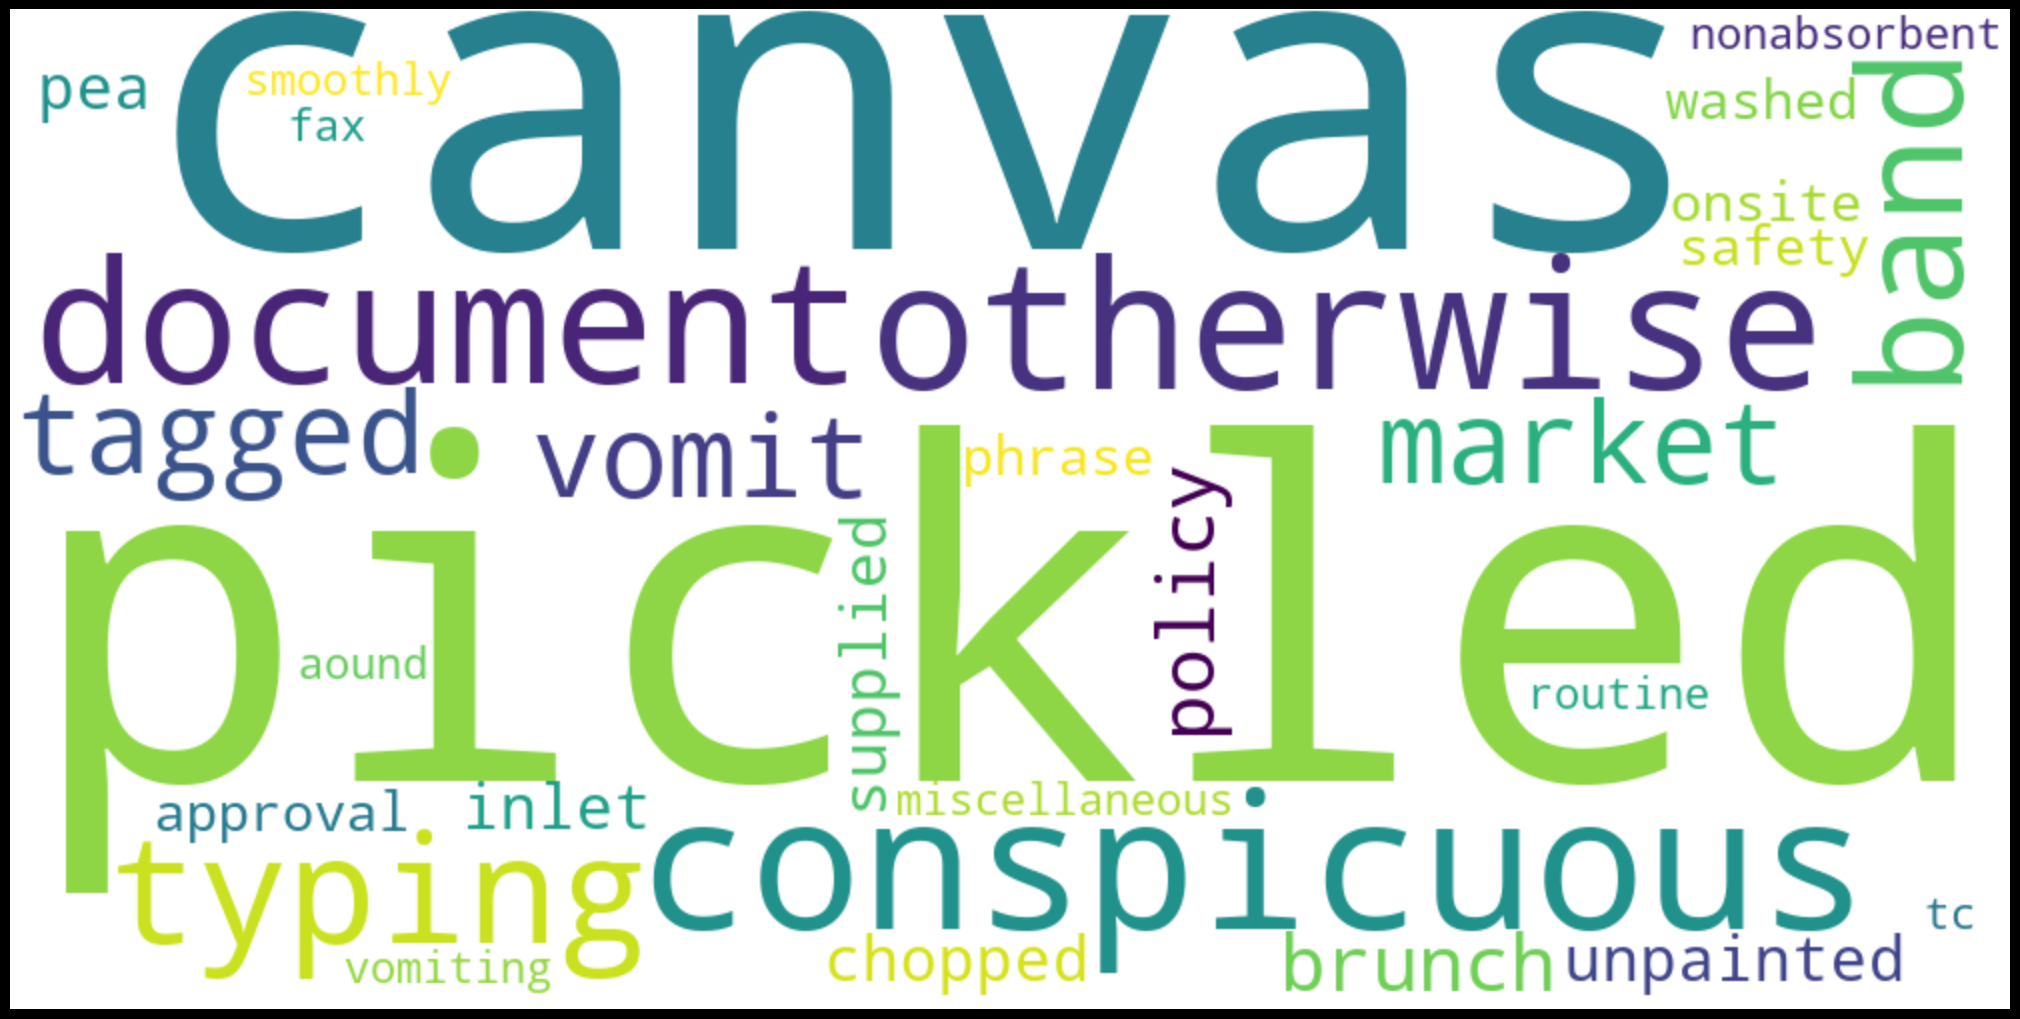

,feature,coefficient
15082,pickled,2.510609
2867,canvas,2.447707
4555,conspicuous,1.942840
14434,otherwise,1.863478
6534,document,1.755431
21858,typing,1.736961
1589,band,1.585244
20695,tagged,1.578757
12742,market,1.573633
22839,vomit,1.563106


In [22]:
important_features_viz(pipeline_count_log.named_steps['clf'], pipeline_count_log.named_steps['vect'], False, 10)

### c. TfidfVectorizer and Naive Bayes

In [23]:
# Define the pipeline
pipeline_tfidf_nb = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf',  MultinomialNB())
])

# Train the model
pipeline_tfidf_nb.fit(X_train, y_train)

# make class predictions for X_test
y_pred_tfidf_nb = pipeline_tfidf_nb.predict(X_test)

# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_tfidf_nb) * 100:.1f}%")

# calculate the confusion matrix
print("Confusion matrix:\n ",metrics.confusion_matrix(y_test, y_pred_tfidf_nb))

# calculate precision and recall
print("Classification Report:\n",classification_report(y_test, y_pred_tfidf_nb))

Test Accuracy: 92.8%
Confusion matrix:
  [[ 9344  1816]
 [  772 24097]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88     11160
           1       0.93      0.97      0.95     24869

    accuracy                           0.93     36029
   macro avg       0.93      0.90      0.91     36029
weighted avg       0.93      0.93      0.93     36029



In [24]:
proba_tfidf_nb = pipeline_tfidf_nb.predict_proba(X_test)

# calculate AUC score 
print(f"AUC Score TfidfVectorizer and Naive Bayes : {roc_auc_score(y_test, proba_tfidf_nb[:, 1])* 100:.1f}%")

AUC Score TfidfVectorizer and Naive Bayes : 96.1%


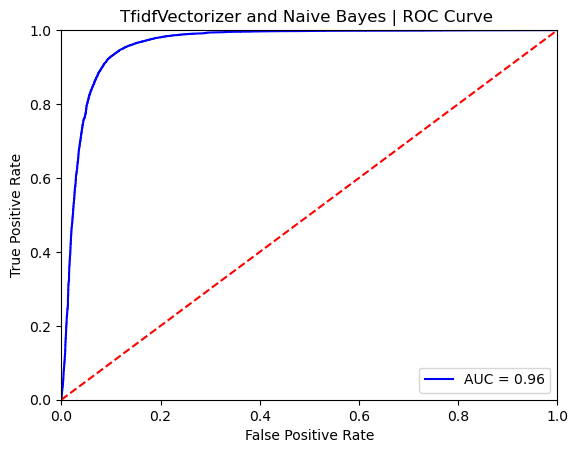

In [25]:
plot_roc_auc_curve(y_test, proba_tfidf_nb[:, 1], 'TfidfVectorizer and Naive Bayes')

### d. TfidfVectorizer and Logistic Regression

In [26]:
# Define the pipeline
pipeline_tfidf_log = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf',  LogisticRegression(max_iter=10000))
])

# Train the model
pipeline_tfidf_log.fit(X_train, y_train)

# make class predictions for X_test
y_pred_tfidf_log = pipeline_tfidf_log.predict(X_test)

# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_tfidf_log) * 100:.1f}%")

# calculate the confusion matrix
print("Confusion matrix:\n ",metrics.confusion_matrix(y_test, y_pred_tfidf_log))

# calculate precision and recall
print("Classification Report:\n",classification_report(y_test, y_pred_tfidf_log))

Test Accuracy: 97.4%
Confusion matrix:
  [[10411   749]
 [  189 24680]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96     11160
           1       0.97      0.99      0.98     24869

    accuracy                           0.97     36029
   macro avg       0.98      0.96      0.97     36029
weighted avg       0.97      0.97      0.97     36029



In [27]:
proba_tfidf_log = pipeline_tfidf_log.predict_proba(X_test)

# calculate AUC score 
print(f"AUC Score TfidfVectorizer and Logistic Regression: {roc_auc_score(y_test, proba_tfidf_log[:, 1])* 100:.1f}%")

AUC Score TfidfVectorizer and Logistic Regression: 99.3%


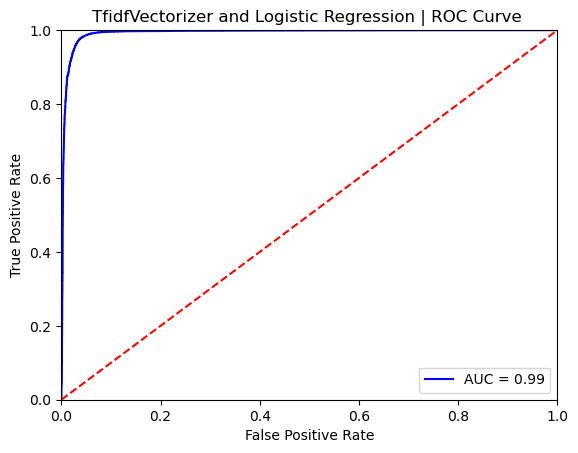

In [28]:
plot_roc_auc_curve(y_test, proba_tfidf_log[:, 1], 'TfidfVectorizer and Logistic Regression')

### Top Features of the FAIL class using TfidfVectorizer + LogisticRegression

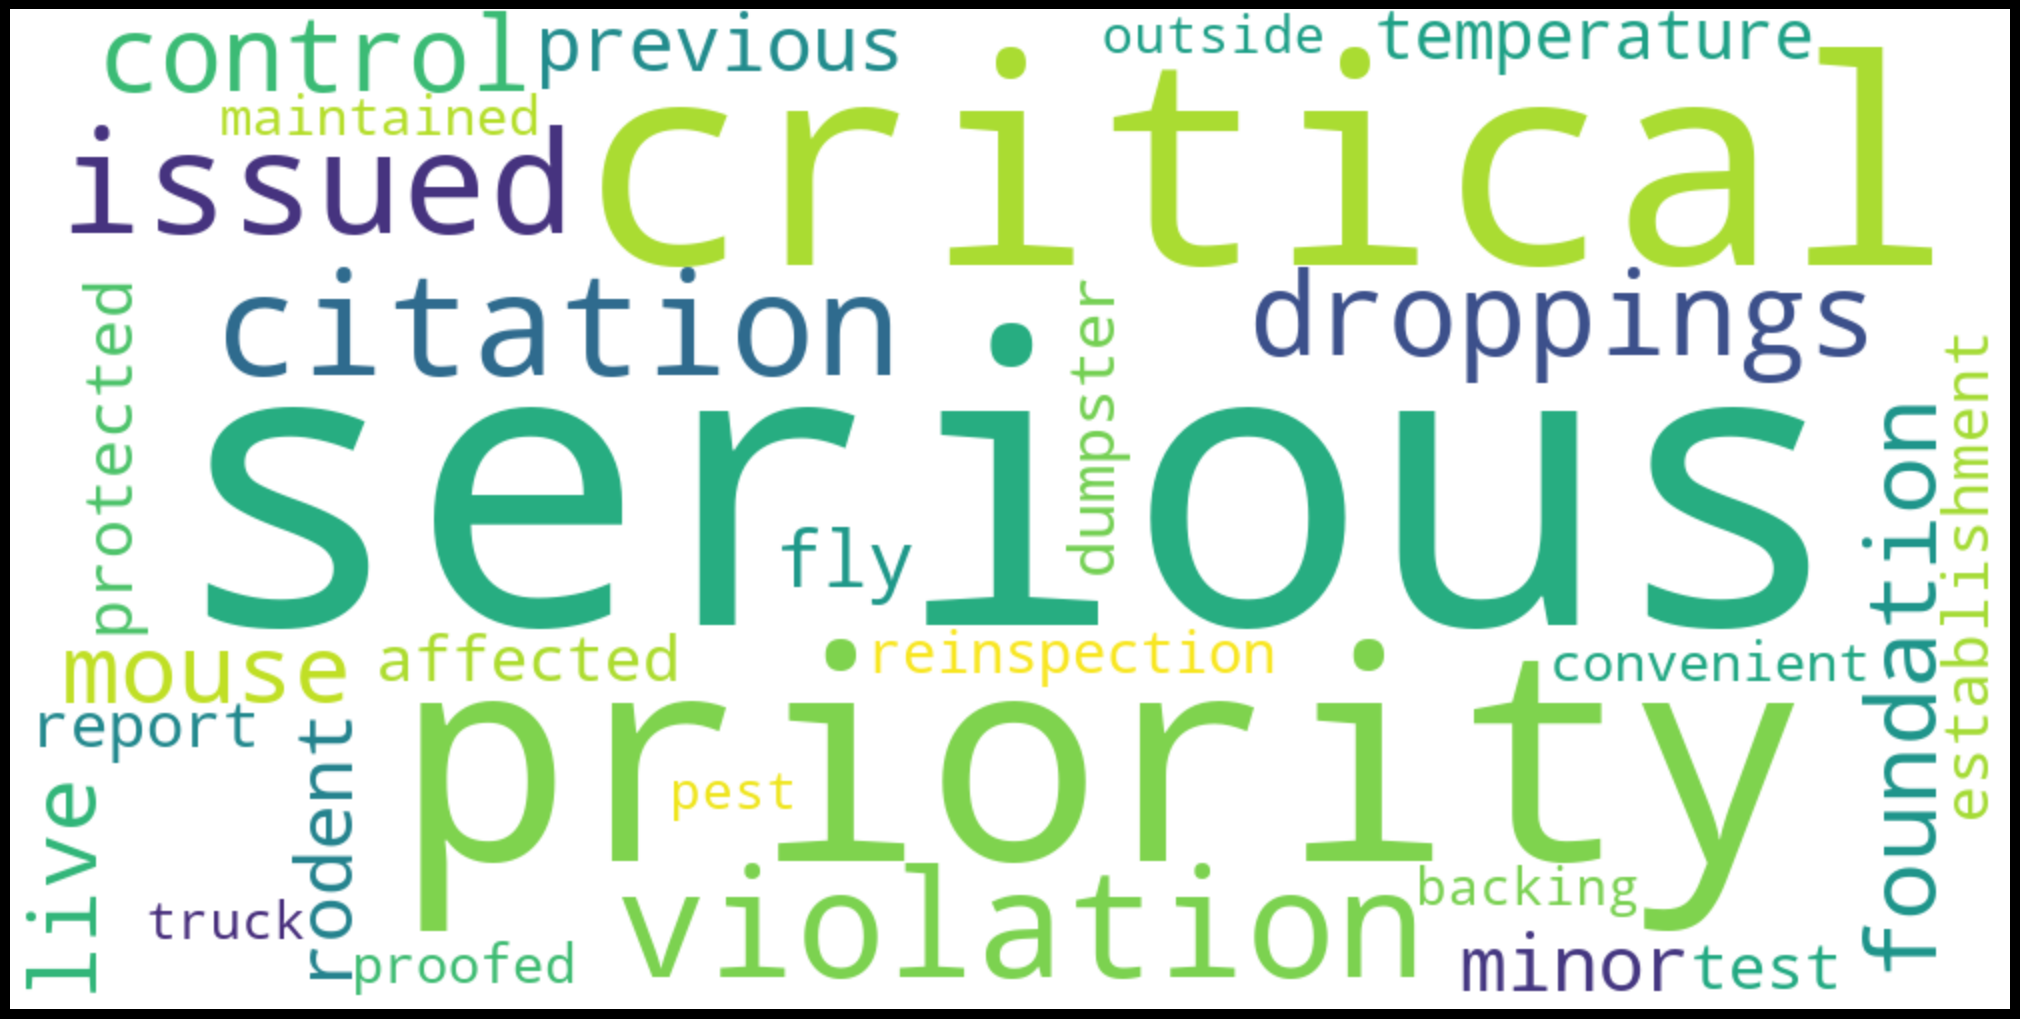

,feature,coefficient
18709,serious,-30.296321
15934,priority,-14.182609
5257,critical,-13.690908
22738,violation,-13.118611
3655,citation,-11.579442
11224,issued,-11.489840
6805,droppings,-11.445195
4749,control,-8.943421
8685,foundation,-8.024578
13356,mouse,-7.732638


In [29]:
important_features_viz(pipeline_tfidf_log.named_steps['clf'], pipeline_tfidf_log.named_steps['vect'], True, -10)

### Top Features of the PASS class using TfidfVectorizer + LogisticRegression

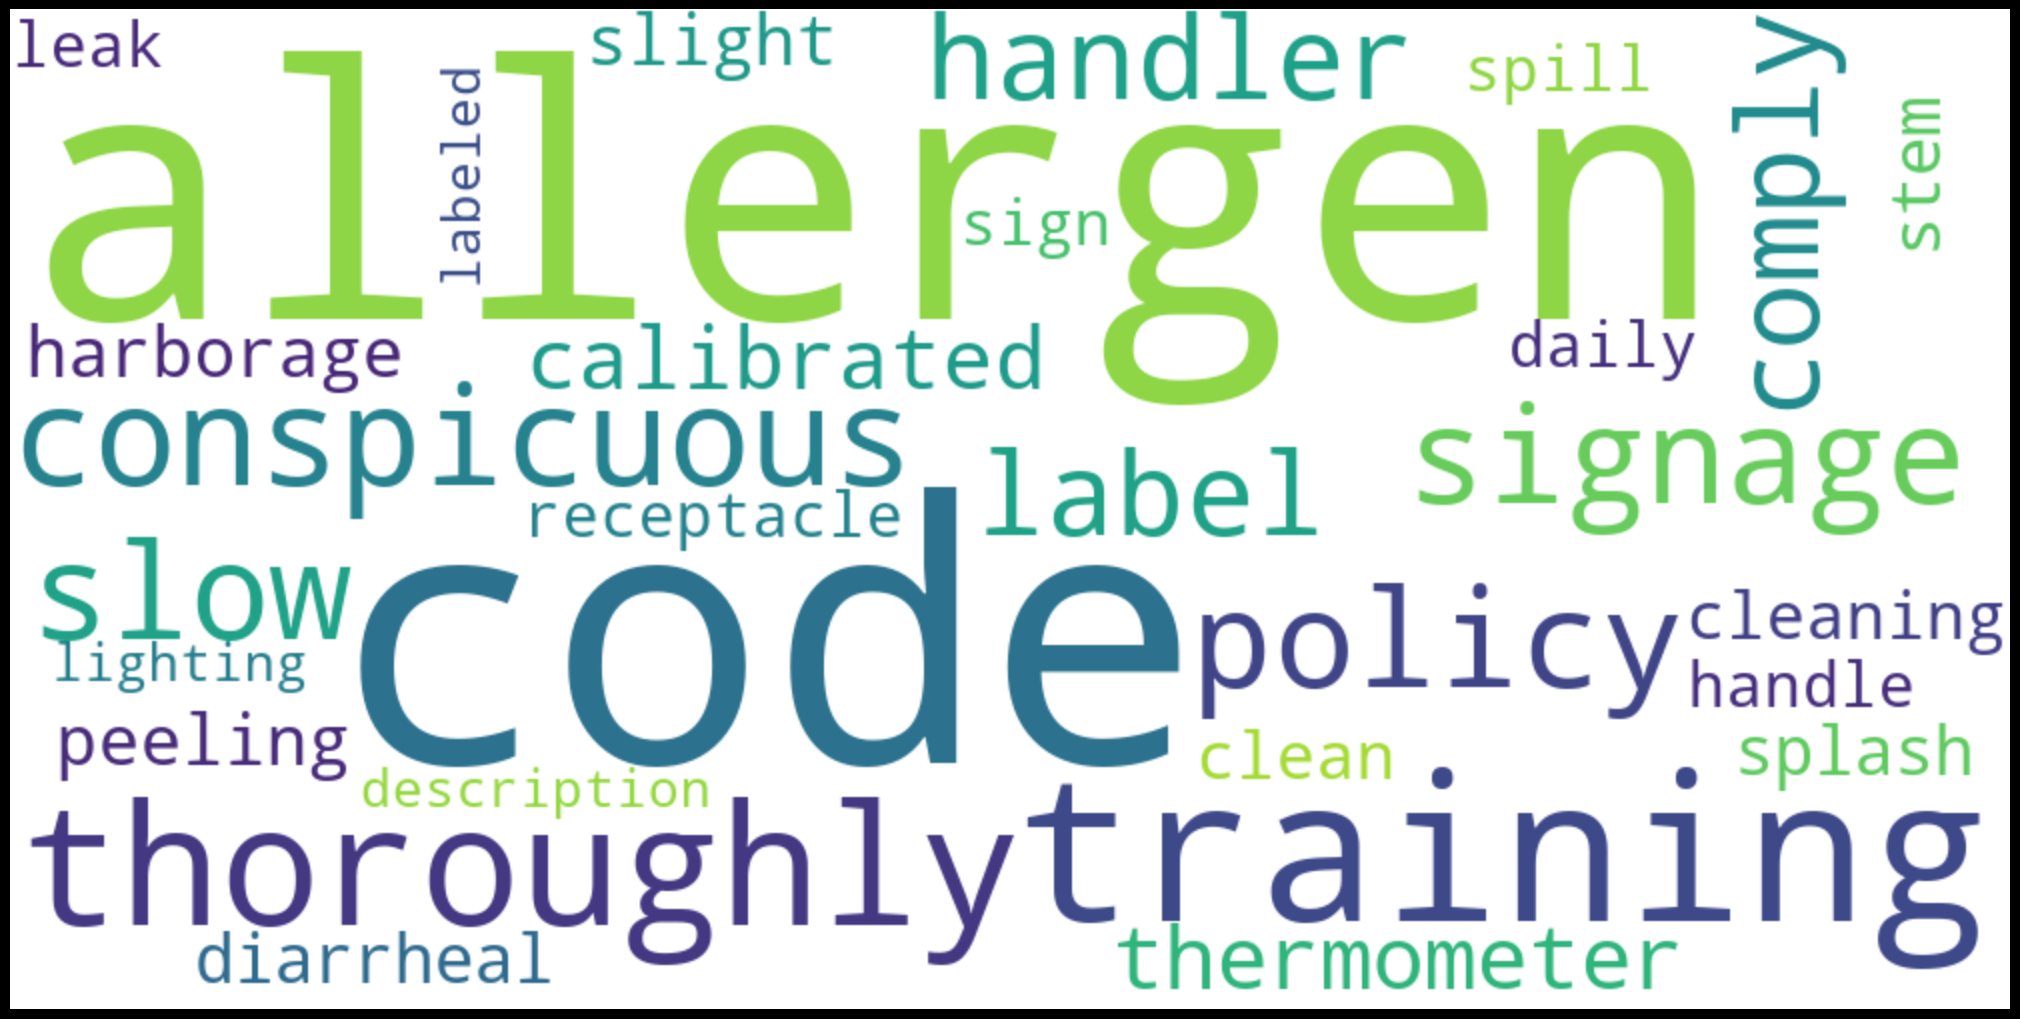

,feature,coefficient
4043,code,3.727330
599,allergen,3.534503
21654,training,3.043913
21191,thoroughly,2.509041
4555,conspicuous,2.359087
15341,policy,2.268603
19358,slow,2.221836
19132,signage,2.211831
9707,handler,2.171040
11650,label,2.167738


In [30]:
important_features_viz(pipeline_tfidf_log.named_steps['clf'], pipeline_tfidf_log.named_steps['vect'], False, 10)

We can observe from the classification report and the ROC curve both the CountVectorizer and TfidfVectorizer give 97% accuracy on the Test data using Logistic Regression. Hence we can confirm that <b>Logistic Regression</b> performs very well for our data on the unigrams. However, we can further improve the performance of the model by fine tuning the parameters of our vectorizer.

## Improving model performance

Performed <b>hyper parameter tuning</b> and using the learnings to improve our model

In [31]:
##### Code that I used for Hyper parameter tuning

# # Define the pipeline
# pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('clf', LogisticRegression())
# ])

# # Define the hyperparameter grid to search over
# params = {
#     'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'vect__max_features': [1000, 5000],
#     'vect_max_df' : [0.8],
#     'vect_min_df' : [0.2]
# }

# # Define the GridSearchCV object
# grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1)

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding score
# print("Best parameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

# # Save the model to a file
# joblib.dump(grid_search.best_estimator_, 'nb_tfidf_model.pkl')


In [32]:
##### Obtained output

# Fitting 5 folds for each of 6 candidates, totalling 30 fits
# Best parameters:  {'vect__max_df': 0.8, 'vect__max_features': 5000, 'vect__min_df': 0.2, 'vect__ngram_range': (1, 3)}
# Best score:  0.8982014331851712

Taking learnings from the outputs of our GridSearchCV we can use the best parameters to improve our <b>Logistic Regression</b> model. 

We know that CountVectorizer simply counts the frequency of each word in a document and represents it as a vector. On the other hand, TF-IDF (Term Frequency-Inverse Document Frequency) takes into account the importance of each word in the document and across the entire corpus. For our dataset since both vectorizers give the same level of accuracy, we can go ahead and attempt to improve our <b>TfidfVectorizer</b>

In [33]:
# Define the pipeline
pipeline_improved = Pipeline([
    ('vect', TfidfVectorizer(ngram_range = (1,3), max_features = 5000)),
    ('clf', LogisticRegression(max_iter=10000))
])

# Train the model on X_train
pipeline_improved.fit(X_train, y_train)

# Make class predictions for X_test
y_pred_improved = pipeline_improved.predict(X_test)

# Calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_improved) * 100:.1f}%")

# Calculate the confusion matrix
print("Confusion matrix:\n ",metrics.confusion_matrix(y_test, y_pred_improved))

# Calculate precision and recall
print("Classification Report:\n",classification_report(y_test, y_pred_improved))

# Calculate AUC score 
proba_improved = pipeline_improved.predict_proba(X_test)
print(f"AUC Score TfidfVectorizer and Logistic Regression: {roc_auc_score(y_test, proba_improved[:, 1])* 100:.1f}%")

Test Accuracy: 97.5%
Confusion matrix:
  [[10441   719]
 [  170 24699]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96     11160
           1       0.97      0.99      0.98     24869

    accuracy                           0.98     36029
   macro avg       0.98      0.96      0.97     36029
weighted avg       0.98      0.98      0.98     36029

AUC Score TfidfVectorizer and Logistic Regression: 99.3%


##### We can see that on fine tuning the parameters to our TfidfVectorizer our model accuracy improved by 0.1%, i.e. from 97.4% to 97.5%

### Top Features of the FAIL class for our improved model

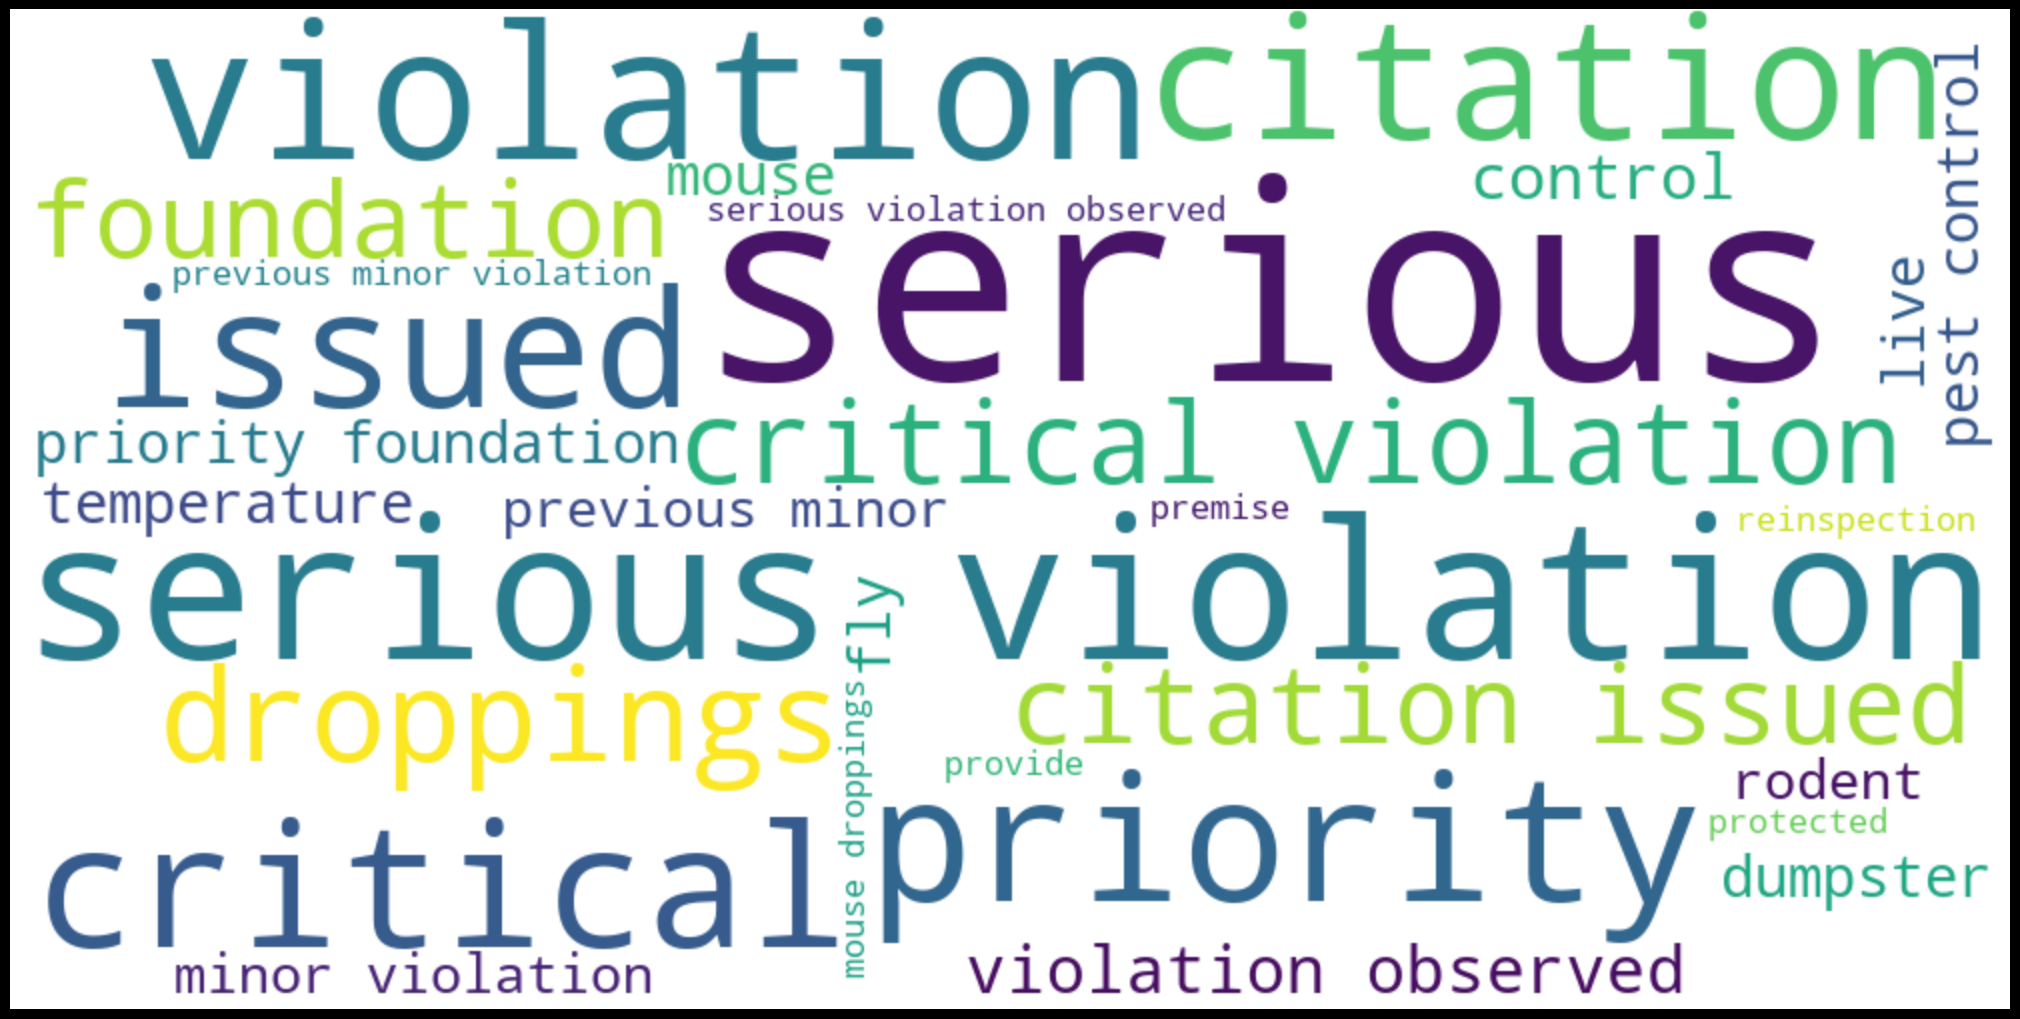

,feature,coefficient
3979,serious,-22.272485
3984,serious violation,-14.279160
4779,violation,-12.984608
3416,priority,-11.386110
1028,critical,-10.964458
533,citation,-10.764690
2388,issued,-10.167619
1300,droppings,-9.239961
1032,critical violation,-7.333476
534,citation issued,-7.302534


In [34]:
important_features_viz(pipeline_improved.named_steps['clf'], pipeline_improved.named_steps['vect'], True, -10)

### Top Features of the PASS class for our improved model

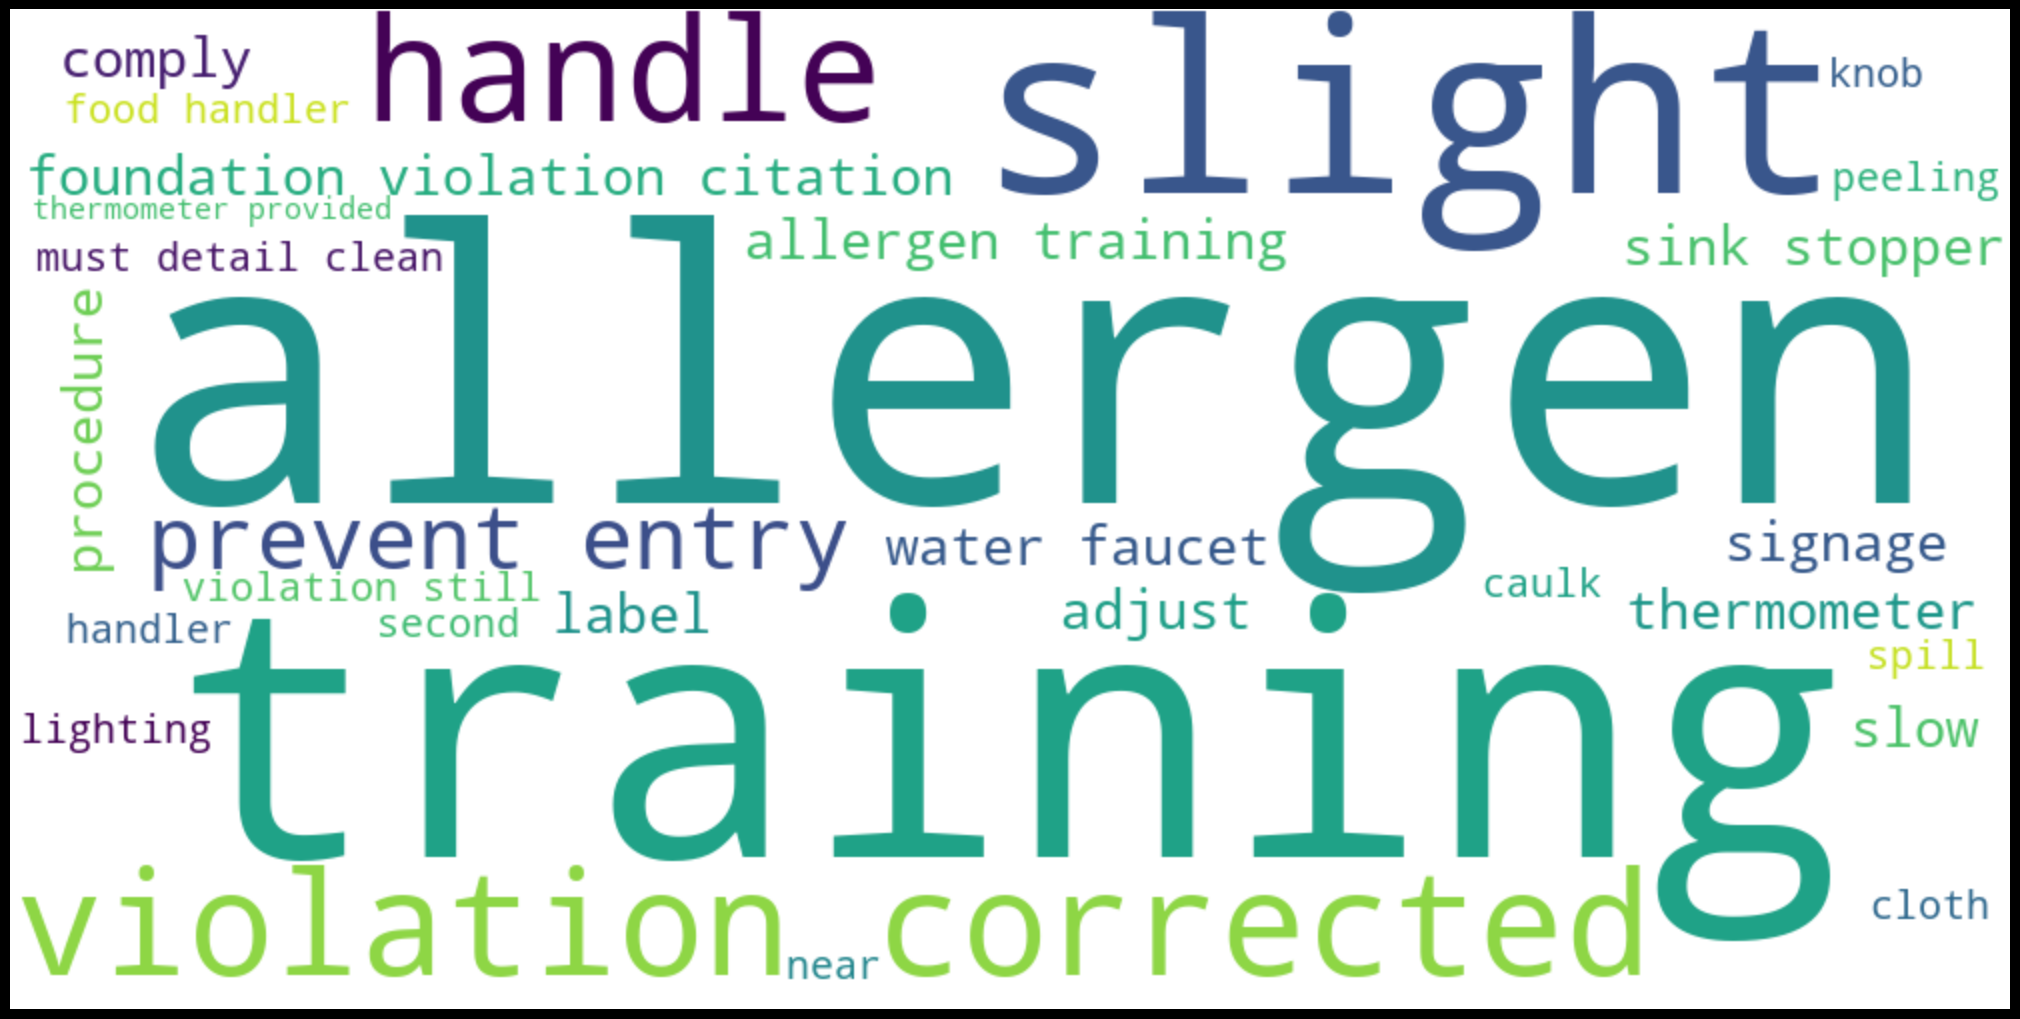

,feature,coefficient
51,allergen,2.541977
4609,training,2.168810
4247,slight,1.903280
4785,violation corrected,1.812673
2030,handle,1.792206
3386,prevent entry,1.742945
1853,foundation violation citation,1.734617
2445,label,1.674829
4505,thermometer,1.639227
4138,signage,1.581900


In [35]:
important_features_viz(pipeline_improved.named_steps['clf'], pipeline_improved.named_steps['vect'], False, 10)

We can clearly see from the top features and the word cloud that these terms are more indicative of Inspection Pass/Fail results and make more logical sense post applying <b>ngrams</b> to our model

### Visualising our results

We know that in our case Fail is our minority class as about 68% of our data is part of the Pass class

In [36]:
inspections.Results.value_counts()

Pass    98680
Fail    45435
Name: Results, dtype: int64

Let us take a look at the distribution of our top features for both the classes as per our improved model. We can understand that the importance is in relevance with the proportion of the Pass and Fail cases in our data.

In [37]:
from nltk.text import Text
# Create a text object from our X
text_obj = Text(nltk.word_tokenize(' '.join(inspections['Comments_Tokens'])))


##### Top feature of our Fail class

In [38]:
inspections[inspections['Comments_Tokens'].str.contains('serious')].Results.value_counts()

Fail    20232
Pass       55
Name: Results, dtype: int64

Displaying 25 of 30021 matches:
st control operator service premise serious must label food storage container f
lose opening make door rodent proof serious violation observed trash recepticle
h recepticles covererd rodent proof serious violation observed original copy ci
 serving potentially hazardous food serious violation observed student bathroom
ot water instructed repair maintain serious violation observed previous minor v
pair maintain reduce eliminate odor serious violation observed tile refridgerat
st control operator service premise serious observed inspection report summary 
stomer view new summary posted time serious must label food storage container f
structed clean sanitize ice machine serious violation found pest control logboo
structed manager clean correct area serious violation outside grease container 
r instructed manager clean maintain serious chemical test strip site adequately
olution instructed provide maintain serious violation previous minor violation 
rovide i

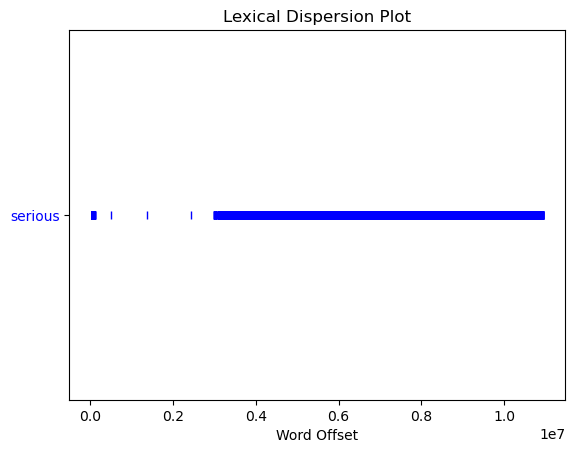

In [39]:
# Generate a concordance for the word
text_obj.concordance('serious')

# Visualize the dispersion of the word
text_obj.dispersion_plot(['serious'])

It is evident that inspection reports with comments containing terms <b>'serious' or 'critical' violation</b> are most likely to <b>fail the inspection.</b>

##### Top feature of our Pass class

In [40]:
inspections[inspections['Comments_Tokens'].str.contains('allergen')].Results.value_counts()

Fail    4459
Pass    2541
Name: Results, dtype: int64

Displaying 25 of 9883 matches:
anitation manager without required allergen training instructed meet requireme
me observed certified food manager allergen training instructed person city ch
e cut must resurface replace proof allergen training certificate city chicago 
raining employee must provide food allergen training certified food manager pi
ust provide maintain observed food allergen training food manager must provide
lean sanitize maintain found proof allergen training site time inspection inst
n amd increase intensity lightning allergen certificate provided site instruct
ee includes bartender must provide allergen training city chicago certified fo
ted report found sanitation manger allergen training must provide priority fou
observed certified manager without allergen training instructed certified mana
ed certified manager must complete allergen training maintain record thereof s
ertificate employee found approved allergen training certificate accordance pa
vice sanitation certi

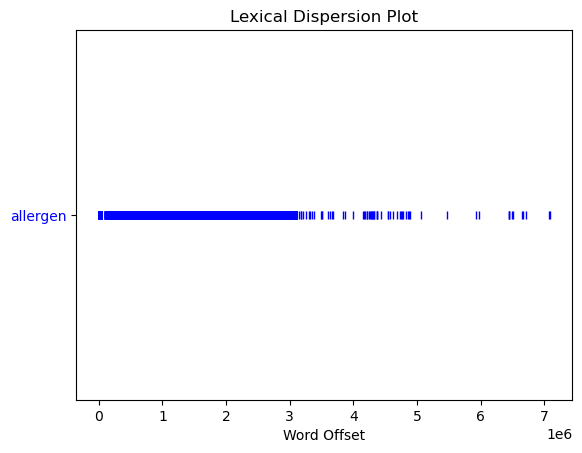

In [41]:
# Generate a concordance for the word
text_obj.concordance('allergen')

# Visualize the dispersion of the word
text_obj.dispersion_plot(['allergen'])

We can observe that a good proportion of inspections that failed as well as passed have comments pertaining to the term <b>'allergen'.</b> However, from the model co-efficients we can determine that violations regarding allergens are minor and less likely to fail the food inspection.

It is safe to conclude that <b>Logistic Regression model with TfidfVectorizer</b> is our best classifier with <b>97.5% accuracy and is quite efficient with about 5000 features and employing unigrams, bigrams and trigrams.</b>

However, from context of our business problem and from looking at our data we can identify that the <b>length of the violation comments</b> can play a huge role in the Result of the inspection. This is because inspections that 'Pass' are more likely to have no comments or fewer comments in comparison as we are extracting the comments from the Violation column and inspections that 'Pass' are less likely to have violations.